Neste documento foi buscado usar os fundamentos de analise e tratamento de dados aprendidos durante a aula para implementar um modelo de predição para prever câncer através de dados clinícos.

1 - Primeiro Passo: Importação de bibliotecas para analise dos dados e implementação dos modelos

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score, confusion_matrix

Para a análise do dataset as seguintes bibliotecas foram utilizadas:
* pandas: Usada para leitura e transformação dos dados
* numpy: Usada para operação aritméticas complexas com vetores e matrizes
* seaborn e matplotlib: Usada para criação e estilização dos gráficos.

Além disso para a criação do modelo de regressão lógica foi utilizado a biblioteca sklearn para baixar o dataset sobre cancer de mama e teste do modelo.

2 - Segundo Passo: Carregar o Dataset

Usando o banco de dados já montado dentro do sklearn para dados clínicos de paciente com cancer maligno e benigno basta carregar o dataset e fazer a análise de dados.

In [3]:

cancer = load_breast_cancer()

df_dataset = pd.DataFrame(data=np.c_[cancer['data'], cancer['target']],
                          columns=np.append(cancer['feature_names'], ['target']))

df_dataset['target'] = df_dataset['target'].map({0: 'malignant', 1: 'benign'})

print('Dados importados com sucesso!')
display(df_dataset.head())

Dados importados com sucesso!


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,malignant


Agora fazendo analise dos dados para encontrar dados faltantes.

In [36]:

valores_ausentes = df_dataset.isnull().sum()

print("Contagem de valores nulos por coluna:")
print(valores_ausentes)

if df_dataset.isnull().values.any():
    print("\nO DataFrame contém valores nulos.")
else:
    print("\nO DataFrame não contém valores nulos.")

# Encontra os índices das linhas que contêm valores nulos
idxRowNan = df_dataset.isnull().any(axis=1).to_numpy().nonzero()

# Imprime apenas as linhas com valores ausentes
print("Linhas com valores nulos:")
display(df_dataset.iloc[idxRowNan])

Contagem de valores nulos por coluna:
mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
target                     0
dtype: int64

O DataFrame não contém valores nulos.
Linhas com 

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target


Fazendo o boxplot para analise de outliers foi verificado vários dados que fogem do padrão.

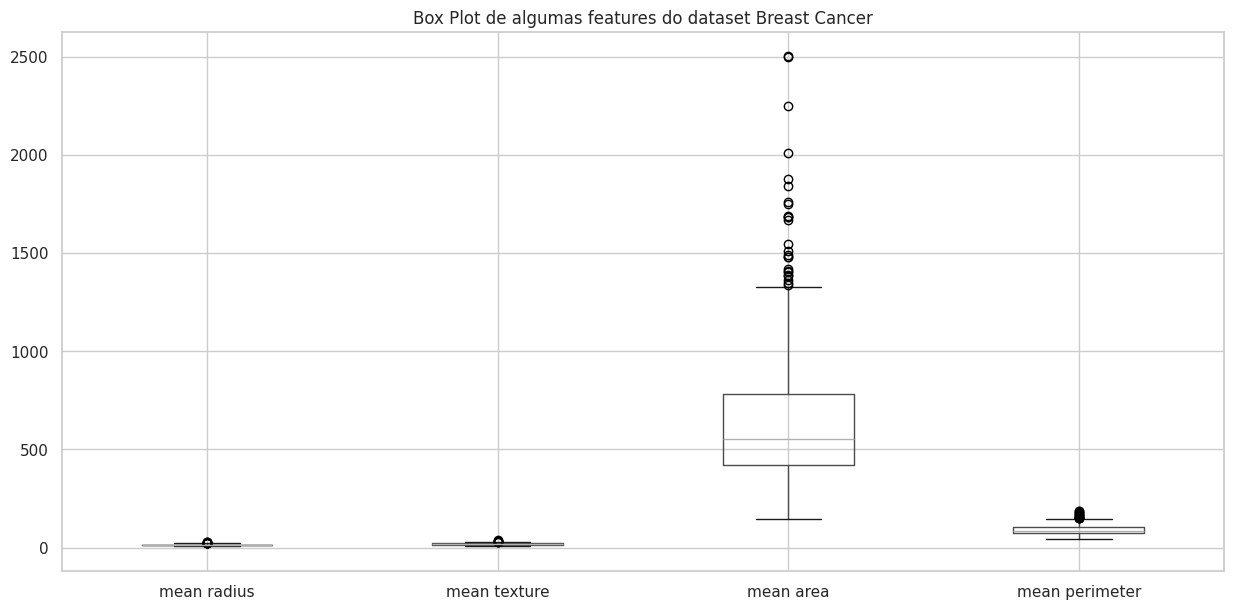

In [37]:

cols_to_plot = ['mean radius', 'mean texture', 'mean area', 'mean perimeter']
df_dataset[cols_to_plot].boxplot(figsize=(15, 7))
plt.title('Box Plot de algumas features do dataset Breast Cancer')
plt.show()


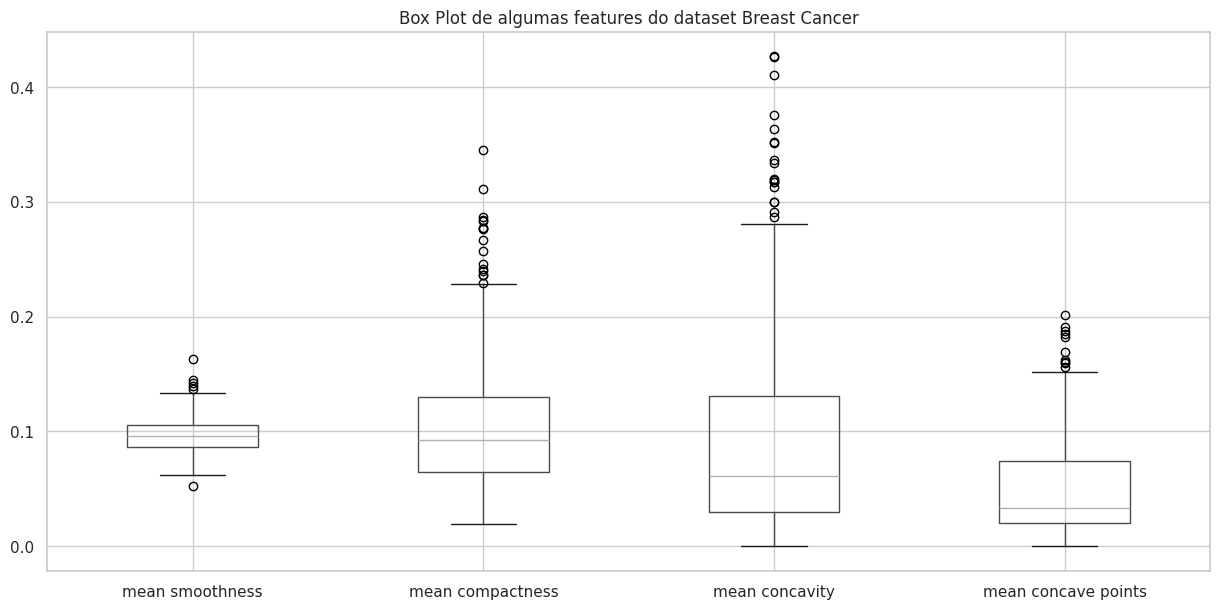

In [38]:
cols_to_plot = ['mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points']
df_dataset[cols_to_plot].boxplot(figsize=(15, 7))
plt.title('Box Plot de algumas features do dataset Breast Cancer')
plt.show()

Removendo os outliers porém gerou um problema com novos outliers.

In [39]:
def removeOutliers(df_dataset):
    df_clean = df_dataset.copy()
    for atributo in df_dataset.columns[:-1]:
        # Obtém o terceiro e o primeiro quartil
        q75, q25 = np.percentile(df_dataset[atributo].values, [75, 25])
        
        # Calcula o Interquartile Range (IQR)
        IQR = q75 - q25
        
        # Define os limites superior e inferior
        upper_bound = q75 + 1.5 * IQR
        lower_bound = q25 - 1.5 * IQR
        
        # Remove os outliers
        df_clean = df_clean[(df_clean[atributo] <= upper_bound) & (df_clean[atributo] >= lower_bound)]
    return df_clean

# Exemplo de como usar a função
print(f"Dimensões do DataFrame antes da remoção: {df_dataset.shape}")

# Chama a função para remover os outliers
df_dataset_sem_outliers = removeOutliers(df_dataset.copy())

print(f"Dimensões do DataFrame após a remoção: {df_dataset_sem_outliers.shape}")

# Exibir os primeiros 5 registros do DataFrame limpo
display(df_dataset_sem_outliers.head())

Dimensões do DataFrame antes da remoção: (569, 31)
Dimensões do DataFrame após a remoção: (398, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
6,18.25,19.98,119.6,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,0.05742,...,27.66,153.2,1606.0,0.1442,0.2576,0.3784,0.19320,0.3063,0.08368,malignant
7,13.71,20.83,90.2,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,0.07451,...,28.14,110.6,897.0,0.1654,0.3682,0.2678,0.15560,0.3196,0.11510,malignant
10,16.02,23.24,102.7,797.8,0.08206,0.06669,0.03299,0.03323,0.1528,0.05697,...,33.88,123.8,1150.0,0.1181,0.1551,0.1459,0.09975,0.2948,0.08452,malignant
11,15.78,17.89,103.6,781.0,0.09710,0.12920,0.09954,0.06606,0.1842,0.06082,...,27.28,136.5,1299.0,0.1396,0.5609,0.3965,0.18100,0.3792,0.10480,malignant
13,15.85,23.95,103.7,782.7,0.08401,0.10020,0.09938,0.05364,0.1847,0.05338,...,27.66,112.0,876.5,0.1131,0.1924,0.2322,0.11190,0.2809,0.06287,malignant


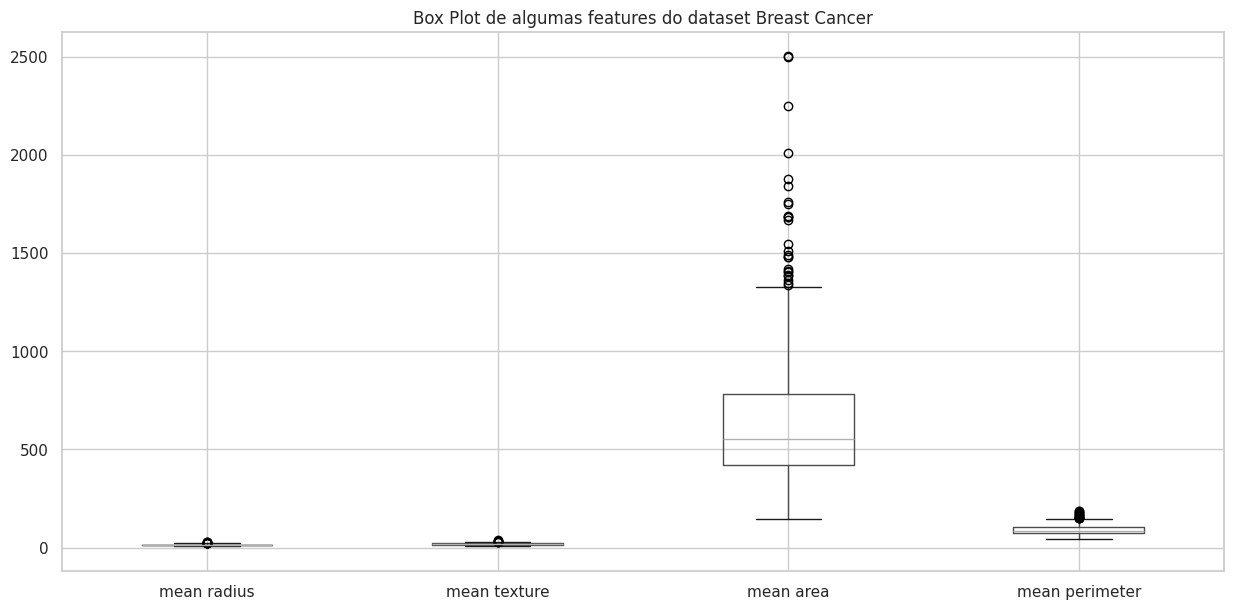

In [40]:
cols_to_plot = ['mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points']
df_dataset[cols_to_plot].boxplot(figsize=(15, 7))
plt.title('Box Plot de algumas features do dataset Breast Cancer')
plt.show()

Mas como evidenciado, como houve novos datasets foi preferenciado usar os dados brutos com outliers usando o sistema de regressão lógistica.
A regressão logística é muito usada em estatística e machine learning, principalmente para classificação binária. Os principais benefícios são:

* Interpretação simples: fornece probabilidades claras de um evento ocorrer (ex.: “sim/não”, “0/1”).

* Resultados probabilísticos: em vez de só classificar, dá a chance de cada classe, útil para decisões com incerteza.

* Baixa complexidade: fácil de treinar e computacionalmente leve, mesmo em bases grandes.

* Menos dados necessários: funciona bem mesmo com datasets menores, desde que não sejam muito complexos.

* Boa interpretabilidade dos coeficientes: os pesos indicam a importância de cada variável na predição.

* Versatilidade: pode ser estendida para classificação multiclasse (softmax / regressão logística multinomial).

* Menor risco de overfitting em comparação com modelos mais complexos, especialmente se for regularizada.

Base teórica sólida: bem compreendida e com muitas ferramentas estatísticas para avaliação (odds ratio, teste de significância, etc.).

In [41]:

X = df_dataset.drop('target', axis=1)
y = df_dataset['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo de Regressão Logística
model = LogisticRegression(max_iter=5000) # Aumentar o max_iter para evitar erros de convergência

model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

# Avaliar o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Acurácia do modelo: {accuracy:.2f}")
print("\nMatriz de Confusão:\n", conf_matrix)
print("\nModelo de predição de câncer de mama construído e avaliado com sucesso!")

Acurácia do modelo: 0.96

Matriz de Confusão:
 [[70  1]
 [ 4 39]]

Modelo de predição de câncer de mama construído e avaliado com sucesso!
